Best parameters for KMeans: {'init': 'k-means++', 'max_iter': 500, 'n_clusters': 2}
Epoch 1/50
89/89 [==============================] - 1s 1ms/step - loss: 0.2789
Epoch 2/50
89/89 [==============================] - 0s 1ms/step - loss: 0.1797
Epoch 3/50
89/89 [==============================] - 0s 1ms/step - loss: 0.1606
Epoch 4/50
89/89 [==============================] - 0s 1ms/step - loss: 0.1501
Epoch 5/50
89/89 [==============================] - 0s 2ms/step - loss: 0.1445
Epoch 6/50
89/89 [==============================] - 0s 1ms/step - loss: 0.1432
Epoch 7/50
89/89 [==============================] - 0s 2ms/step - loss: 0.1425
Epoch 8/50
89/89 [==============================] - 0s 2ms/step - loss: 0.1424
Epoch 9/50
89/89 [==============================] - 0s 1ms/step - loss: 0.1420
Epoch 10/50
89/89 [==============================] - 0s 1ms/step - loss: 0.1418
Epoch 11/50
89/89 [==============================] - 0s 2ms/step - loss: 0.1417
Epoch 12/50
89/89 [==========================

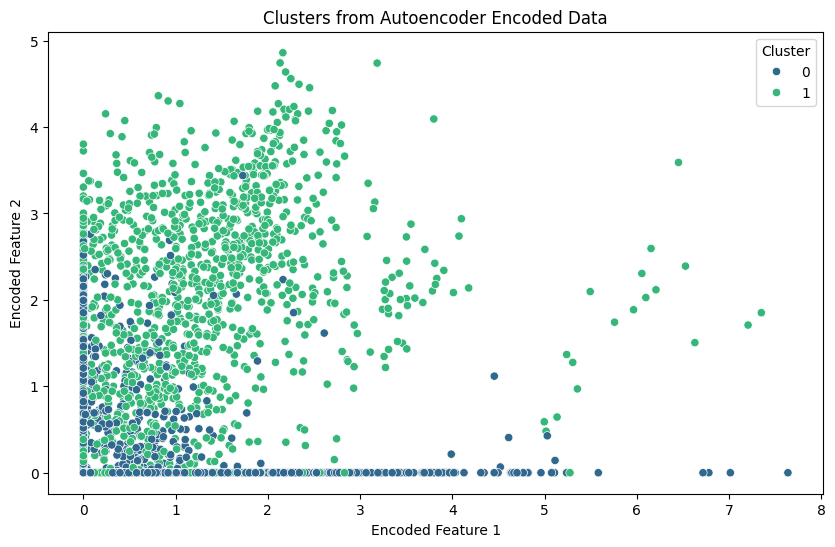

In [4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.impute import SimpleImputer

# Load the dataset (replace with your actual path or URL)
CustomerDataset = pd.read_csv("D:\Customer-Segmentation_End-to-end-Project-master\sales_data_sample.csv")

# Preprocessing
# Convert 'ORDERDATE' to datetime and create a numeric representation
CustomerDataset['ORDERDATE'] = pd.to_datetime(CustomerDataset['ORDERDATE'])
CustomerDataset['ORDERDATE_NUMERIC'] = (CustomerDataset['ORDERDATE'] - CustomerDataset['ORDERDATE'].min()).dt.days

# Drop unnecessary columns
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY',
            'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME',
            'ORDERNUMBER', "ORDERDATE", "QTR_ID", "ORDERLINENUMBER", "YEAR_ID", "PRODUCTCODE"]
Dataset = CustomerDataset.drop(to_drop, axis=1)

# Define numerical and categorical features
numeric_features = ['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'MSRP', 'ORDERDATE_NUMERIC']
categorical_features = ['STATUS', 'PRODUCTLINE', 'DEALSIZE']

# Create preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

# Apply preprocessing
dataset_prepared = preprocessor.fit_transform(Dataset)

# 1. Hyperparameter Tuning for KMeans


def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# No need for make_scorer here, you can directly use silhouette_scorer
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500],
}

grid_search = GridSearchCV(KMeans(), param_grid, cv=5, scoring=silhouette_scorer)
grid_search.fit(dataset_prepared)

print("Best parameters for KMeans:", grid_search.best_params_)
best_kmeans = grid_search.best_estimator_

# 2. Deep Learning (Autoencoder)
input_layer = Input(shape=(dataset_prepared.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(dataset_prepared.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(dataset_prepared, dataset_prepared, epochs=50, batch_size=32)

# Create an encoder model to obtain the encoded representation
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(dataset_prepared)

# Apply KMeans to the encoded data
kmeans_deep = KMeans(n_clusters=grid_search.best_params_['n_clusters'], 
                     init=grid_search.best_params_['init'], 
                     max_iter=grid_search.best_params_['max_iter'])
kmeans_deep.fit(encoded_data)

# Add cluster labels to the original dataset for analysis
Dataset['Cluster'] = kmeans_deep.labels_

# Optionally visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=Dataset['Cluster'], palette='viridis')
plt.title('Clusters from Autoencoder Encoded Data')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.show()


In [6]:
inertia_deep = kmeans_deep.inertia_
labels_deep = kmeans_deep.labels_
silhouette_deep = silhouette_score(encoded_data, labels_deep)

print("Deep Learning Model - Inertia:", inertia_deep)
print("Deep Learning Model - Silhouette Score:", silhouette_deep)

Deep Learning Model - Inertia: 133545.109375
Deep Learning Model - Silhouette Score: 0.22464816
